# Ryzyko rynkowe
## Importy

In [1]:
#pip install numpy pandas seaborn matplotlib yfinance scipy pymannkendall statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller

## Pobranie danych przez API

Źródło danych Yahoo Finance: https://finance.yahoo.com/chart/NVDA.

In [2]:
data = yf.download("NVDA", start="2023-01-01", end="2023-12-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
#data.to_csv("data/NVDA_data.csv")

## Eksploracyjna analiza danych

In [4]:
#data = pd.read_csv("data/NVDA_data.csv", header=[0, 1], index_col=0, parse_dates=True)
print(data.head())

Price                      Adj Close   Close    High     Low    Open  \
Ticker                          NVDA    NVDA    NVDA    NVDA    NVDA   
Date                                                                   
2023-01-03 00:00:00+00:00  14.305582  14.315  14.996  14.096  14.851   
2023-01-04 00:00:00+00:00  14.739296  14.749  14.853  14.241  14.567   
2023-01-05 00:00:00+00:00  14.255614  14.265  14.564  14.148  14.491   
2023-01-06 00:00:00+00:00  14.849223  14.859  15.010  14.034  14.474   
2023-01-09 00:00:00+00:00  15.617718  15.628  16.056  15.141  15.284   

Price                         Volume  
Ticker                          NVDA  
Date                                  
2023-01-03 00:00:00+00:00  401277000  
2023-01-04 00:00:00+00:00  431324000  
2023-01-05 00:00:00+00:00  389168000  
2023-01-06 00:00:00+00:00  405044000  
2023-01-09 00:00:00+00:00  504231000  


Pobraliśmy dzienne dane cen akcji NVDA z 2023 roku. Możemy sprawdzić wymiary zbioru danych:

In [5]:
print(data.shape)

(250, 6)


Zbiór ma sześć kolumn, ale tylko 250 wierszy (dni). Wynika to z tego, że dane są zapisywane tylko dla dni, w których rynki były otwarte, co oznacza, że weekendy i święta mogą być pominięte. Zatem liczba dni handlowych w 2023 roku wynosiła 250. Sprawdzimy różnice w indeksach:

In [6]:
data.index.to_series().diff().value_counts()

Date
1 days    196
3 days     44
4 days      7
2 days      2
Name: count, dtype: int64

- Największa liczba dni handlowych (196) występuje z różnicą 1 dnia - większość kolejnych wpisów pochodzi z dni roboczych.
- Różnica 3 dni odpowiada przerwom weekendowym, gdy giełda jest zamknięta w soboty i niedziele.
- Różnica 4 dni wynika z przedłużonych weekendów.
- Różnica 2 dni jest rzadsza i może wskazywać na skrócone tygodnie handlowe, gdy święto przypada na inny dzień niż piątek lub poniedziałek.

Dane mają sześć kolumn o nazwach:

In [7]:
print(data.columns)

MultiIndex([('Adj Close', 'NVDA'),
            (    'Close', 'NVDA'),
            (     'High', 'NVDA'),
            (      'Low', 'NVDA'),
            (     'Open', 'NVDA'),
            (   'Volume', 'NVDA')],
           names=['Price', 'Ticker'])


Nagłówek kolumn jest wielopoziomowy. Możemy go spłaszczyć, aby łatwiej odnosić się do konkretnych kolumn:

In [8]:
data.columns = ["_".join(col).strip() for col in data.columns]
print(data.columns)

Index(['Adj Close_NVDA', 'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA',
       'Volume_NVDA'],
      dtype='object')


Wyświetlimy podstawowe informacje o zbiorze danych:

In [9]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close_NVDA  250 non-null    float64
 1   Close_NVDA      250 non-null    float64
 2   High_NVDA       250 non-null    float64
 3   Low_NVDA        250 non-null    float64
 4   Open_NVDA       250 non-null    float64
 5   Volume_NVDA     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB
None


Indeks:
- Indeks składa się z dat i godzin. Dane obejmują okres od 3 stycznia 2023 (pierwszy dzień handlowy) do 29 grudnia 2023 (ostatni dzień handlowy). W zbiorze jest 250 wierszy, co odpowiada liczbie dni handlowych w 2023 roku.

Opis kolumn:
- **Adj Close_NVDA**: skorygowana cena zamknięcia, uwzględnia takie zdarzenia jak podział akcji (split) czy dywidendy.
- **Close_NVDA**: cena zamknięcia w danym dniu, czyli ostatnią cenę, po której akcje były handlowane na koniec dnia giełdowego.
- **High_NVDA**: najwyższa cena w ciągu dnia handlowego.
- **Low_NVDA**: najniższa cena w ciągu dnia handlowego.
- **Open_NVDA**: cena otwarcia, czyli pierwsza cena, po której akcje były handlowane w danym dniu.
- **Volume_NVDA**: liczba akcji, która zmieniła właściciela tego dnia.

Typy danych w kolumnach:
- float64 (5 kolumn): Kolumny z wartościami liczbowymi zmiennoprzecinkowymi (ceny akcji).
- int64 (1 kolumna): Kolumna z wartościami całkowitymi (wolumen obrotu).

Możemy też sprawdzić podstawowe statysktyki zbioru:

In [10]:
print(data.describe())

       Adj Close_NVDA  Close_NVDA   High_NVDA    Low_NVDA   Open_NVDA  \
count      250.000000  250.000000  250.000000  250.000000  250.000000   
mean        36.555016   36.569260   37.123132   35.926540   36.515168   
std         10.755648   10.756455   10.916913   10.657784   10.849127   
min         14.255614   14.265000   14.564000   14.034000   14.474000   
25%         26.886616   26.899750   27.171000   26.428500   26.831000   
50%         41.879105   41.893499   42.503000   40.962500   41.635500   
75%         45.629621   45.646250   46.223248   44.988249   45.770749   
max         50.393753   50.409000   50.548000   49.411999   50.216000   

        Volume_NVDA  
count  2.500000e+02  
mean   4.735575e+08  
std    1.614028e+08  
min    1.982090e+08  
25%    3.790238e+08  
50%    4.341845e+08  
75%    5.172652e+08  
max    1.543911e+09  


Wnioski:
- Wszystkie kolumny mają 250 wartości (zgodne z liczbą dni handlowych w 2023 roku). Brak danych nie występuje.
- Akcje miały średnią cenę na poziomie 36.56 USD, ale mediana 41.88 USD (percentyl 50%) wskazuje, że ceny częściej oscylowały wokół wyższych wartości.
- Rozpiętość między minimum (14.26 USD) a maksimum (50.39 USD) jest bardzo duża, co sugeruje znaczne wahania cen w ciągu roku.
- Rozkład cen w kwartylach pokazuje, że przez większość roku ceny akcji znajdowały się w przedziale ~27-46 USD.
- Średni wolumen obrotu był wysoki (~473 milionów akcji dziennie), ale znaczne odchylenie standardowe (161,402,800 akcji) wskazuje na duże różnice w aktywności inwestorów w poszczególnych dniach.

Interesuje nas kolumna Close_NVDA. Możemy przedstawić szereg czasowy cen zamknięcia na wykresie:

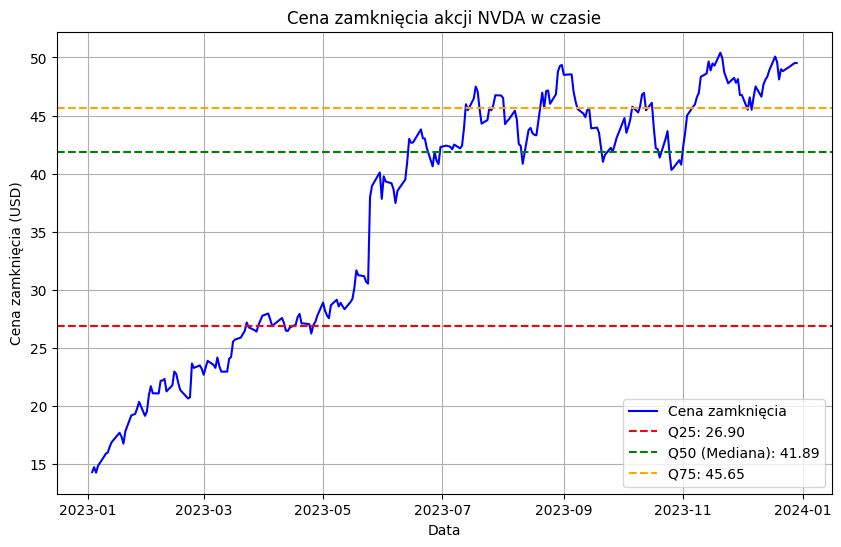

In [11]:
q25 = data["Close_NVDA"].quantile(0.25)
q50 = data["Close_NVDA"].quantile(0.50)
q75 = data["Close_NVDA"].quantile(0.75)

plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Close_NVDA"], color='blue', label="Cena zamknięcia")
plt.xlabel("Data")
plt.ylabel("Cena zamknięcia (USD)")
plt.title("Cena zamknięcia akcji NVDA w czasie")

plt.axhline(y=q25, color='red', linestyle='--', label=f'Q25: {q25:.2f}')
plt.axhline(y=q50, color='green', linestyle='--', label=f'Q50 (Mediana): {q50:.2f}')
plt.axhline(y=q75, color='orange', linestyle='--', label=f'Q75: {q75:.2f}')

plt.legend()
plt.grid()
plt.show()

Widzimy rosnący trend, co możemy potwierdzić testem Manna-Kendalla. Jest to test nieparametryczny test statystyczny (nie zakłada żadnego konkretnego rozkładu danych), który służy do wykrywania trendu w szeregach czasowych.
- Jeśli wartość statystyki testu jest dodatnia, oznacza to, że dane mają tendencję rosnącą.
- Jeśli wartość statystyki testu jest ujemna, oznacza to, że dane mają tendencję malejącą.
- Jeśli wartość testu jest bliska zeru, to oznacza, że w danych nie widać wyraźnego trendu.

In [12]:
trend_test = mk.original_test(data['Close_NVDA'])
print(f"Trend: {trend_test.trend}")
print(f"Nachylenie: {trend_test.slope}")
print(f"p-value: {trend_test.p}")

Trend: increasing
Nachylenie: 0.1361297723901181
p-value: 0.0


Test potwierdza obecność trednu rosnącego. Zróżnicowanie danych może pomóc w usunięciu trendu i sprawieniu, by szereg czasowy stał się stacjonarny (czyli jego statystyki (średnia, wariancja, kowariancja) nie zmieniały się w czasie).

## Zróżnicowanie szeregu czasowego Close_NVDA
Nasze dane są nieciągłe (brakuje weekendów i świąt), więc różnicowanie będzie dotyczyło tylko dni handlowych. Uzupełnianie brakujących dni sztucznymi wartościami (np. przez forward fill) może wprowadzić fałszywe informacje do analizy. W rezultacie uwzględniamy tylko rzeczywiste zmiany cen w dostępnych datach.

In [13]:
data["diff"] = data["Close_NVDA"].diff()
data = data.dropna(subset=["diff"])

Sprawdzimy jak zmieniły się dane na wykresie:

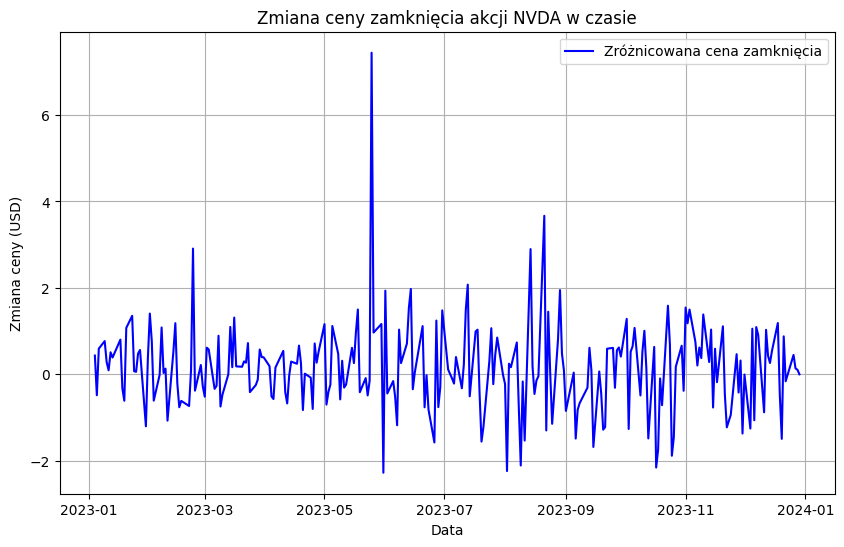

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["diff"], color='blue', label="Zróżnicowana cena zamknięcia")
plt.xlabel("Data")
plt.ylabel("Zmiana ceny (USD)")
plt.title("Zmiana ceny zamknięcia akcji NVDA w czasie")

plt.legend()
plt.grid()
plt.show()

Na wykresie nie zauważamy wyraźnego trendu. Sprawdzimy to za pomocą testu Manna-Kendalla:

In [15]:
trend_test = mk.original_test(data["diff"])
print(f"Trend: {trend_test.trend}")
print(f"Nachylenie: {trend_test.slope}")
print(f"p-value: {trend_test.p}")

Trend: no trend
Nachylenie: -0.00042856027791788286
p-value: 0.5758077879200196


Test potwierdza pozbycie się trendu. Możemy również przetestować stacjonarność zróżnicowanego szeregu za pomocą rozszerzonego testu Dickey-Fullera (ADF), który sprawdza, czy szereg ma jednostkowy pierwiastek (co sugerowałoby, że jest niestacjonarny). Jeśli p-value testu ADF będzie małe (np. poniżej 0.05), oznacza to, że po zróżnicowaniu szereg stał się stacjonarny:

In [16]:
result = adfuller(data["diff"].dropna())
print("p-value:", result[1])

p-value: 1.9633743212453096e-28


Wartość p-value ($1.96 \times 10^{-28}$) jest bardzo bliska zeru, co sugeruje, że szereg czasowy jest stacjonarny. Możemy sprawdzić wartości odstające:

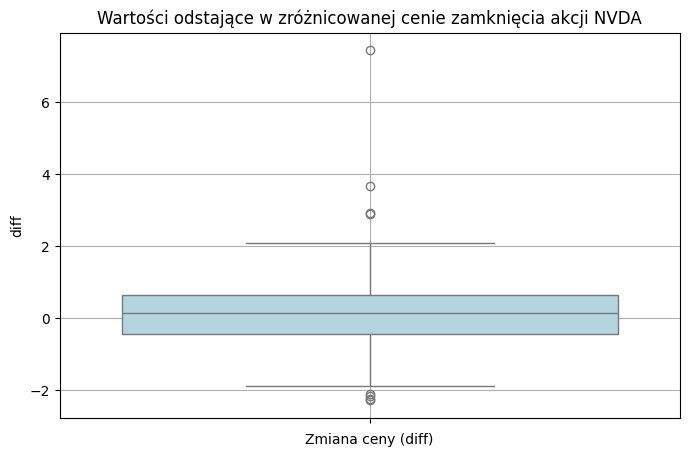

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data["diff"], color='lightblue')
plt.title("Wartości odstające w zróżnicowanej cenie zamknięcia akcji NVDA")
plt.xlabel("Zmiana ceny (diff)")
plt.grid(True)
plt.show()

- Mediana (środkowa linia w pudełku) różnicy cen zamknięcia akcji NVDA wynosi około 0, co sugeruje, że większość zmian cen oscyluje wokół tej wartości.
- Pudełko obejmuje zakres od pierwszego do trzeciego kwartylu, co oznacza, że 50% danych znajduje się w przedziale od około -1 do 1.
- Wykres pokazuje kilka wartości odstających, które są zaznaczone jako pojedyncze punkty powyżej i poniżej wąsów. Wartości te są znacznie wyższe lub niższe niż reszta danych, co może wskazywać na nietypowe zmiany cen.
- Wąsy rozciągają się od dolnego do górnego limitu, co pokazuje pełny zakres danych z wyłączeniem wartości odstających.

Możemy również wyświetlić statystyki zróżnicowanego szeregu:

In [18]:
print(data["diff"].describe())

count    249.000000
mean       0.141394
std        1.017007
min       -2.277000
25%       -0.443001
50%        0.139000
75%        0.634003
max        7.441999
Name: diff, dtype: float64


- Średnia zmiana ceny jest dodatnia (0.141 USD), co sugeruje, że akcje NVDA generalnie rosły w badanym okresie.
- Wysokie odchylenie standardowe (1.02 USD) oznacza, że ceny zmieniały się znacznie z dnia na dzień, co wskazuje na dużą zmienność.
- Rozkład jest asymetryczny, ponieważ mediana (0.139 USD) jest bliska średniej, ale 25. percentyl jest ujemny (-0.443 USD), co sugeruje, że niektóre dni miały większe straty niż zyski.
- Wartości ekstremalne (np. maksymalna zmiana 7.442 USD) mogą wskazywać na duże wahania cen w okresach dużych wzrostów.

## Analiza rozkładu
Za pomocą histogramu możemy zobaczyć, jak rozkładają się wartości w zróżnicowanym szeregu:

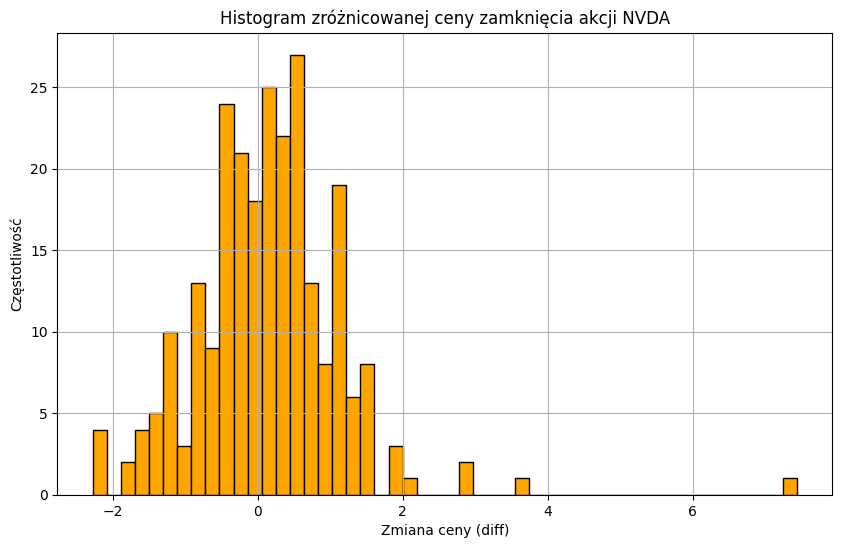

In [19]:
plt.figure(figsize=(10, 6))
data["diff"].hist(bins=50, edgecolor='k', color='orange')
plt.title("Histogram zróżnicowanej ceny zamknięcia akcji NVDA")
plt.xlabel("Zmiana ceny (diff)")
plt.ylabel("Częstotliwość")
plt.grid(True)
plt.show()

- Najwięcej zmian ceny zamknięcia akcji NVDA oscyluje wokół wartości 0, co oznacza, że najczęściej cena zamknięcia nie zmieniała się znacząco.
- Większość zmian ceny mieści się w przedziale od -2 do 2, co sugeruje, że zmiany ceny zamknięcia akcji NVDA są zazwyczaj niewielkie.
- Istnieje kilka przypadków, gdzie zmiana ceny była większa niż 4, ale są one rzadkie.
- Histogram jest asymetryczny, z większą liczbą przypadków po stronie dodatnich zmian ceny.

Na podstawie histogramu, nasze dane mogą mieć rozkład normalny (rozkład Gaussa), ponieważ większość wartości skupia się wokół średniej (0), a liczba obserwacji maleje symetrycznie w miarę oddalania się od średniej. Jednakże, po prawej stronie widzimy pewne odchylenia od idealnego rozkładu normalnego (wartości skrajne).

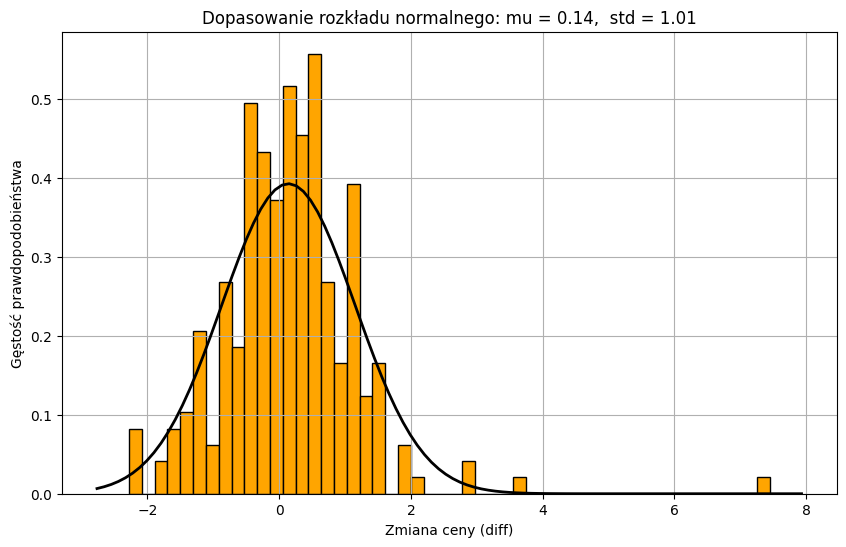

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(data["diff"], bins=50, density=True, color='orange', edgecolor='k')

# dopasowanie rozkładu normalnego
mu, std = norm.fit(data["diff"])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title(f"Dopasowanie rozkładu normalnego: mu = {mu:.2f},  std = {std:.2f}")
plt.xlabel("Zmiana ceny (diff)")
plt.ylabel("Gęstość prawdopodobieństwa")
plt.grid(True)
plt.show()

wnioski...
- gruby ogon z prawej strony...

## Kalkulacja VaR
### a) Obliczanie VaR przy założeniu rozkładu normalnego

Policzymy średnią ($\mu$) i odchylenie standardowe ($\sigma$):

In [21]:
mu = data["diff"].mean()
sigma = data["diff"].std()
print(f"Mu: {mu}")
print(f"Sigma: {sigma}")

Mu: 0.14139357340862474
Sigma: 1.0170069562269453


Definiujemy poziom ufności $\alpha$ 5% i 1%:

In [22]:
alpha_95 = 0.05
alpha_99 = 0.01

Obliczamy Value at Risk czyli wielkość najgorszej straty przy poziomie ufności $\alpha$ 5% i 1%:

In [23]:
VaR_95 = norm.ppf(alpha_95, loc=mu, scale=sigma)
VaR_99 = norm.ppf(alpha_99, loc=mu, scale=sigma)

In [24]:
print(f"VaR 95% (rozkład normalny): {VaR_95}")
print(f"VaR 99% (rozkład normalny): {VaR_99}")

VaR 95% (rozkład normalny): -1.531434007176144
VaR 99% (rozkład normalny): -2.2245183970946756


### b) Obliczanie VaR dla rozkładu historycznego

Dla podejścia historycznego wystarczy policzyć odpowiedni kwantyl:

In [25]:
VaR_95_hist = data["diff"].quantile(alpha_95)
VaR_99_hist = data["diff"].quantile(alpha_99)

In [26]:
print(f"VaR 95% (rozkład historyczny): {VaR_95_hist}")
print(f"VaR 99% (rozkład historyczny): {VaR_99_hist}")

VaR 95% (rozkład historyczny): -1.471600341796875
VaR 99% (rozkład historyczny): -2.134441070556641


Możemy porównać VaR parametryczny (z rozkładu normalnego) i VaR historyczny za pomocą wykresu:

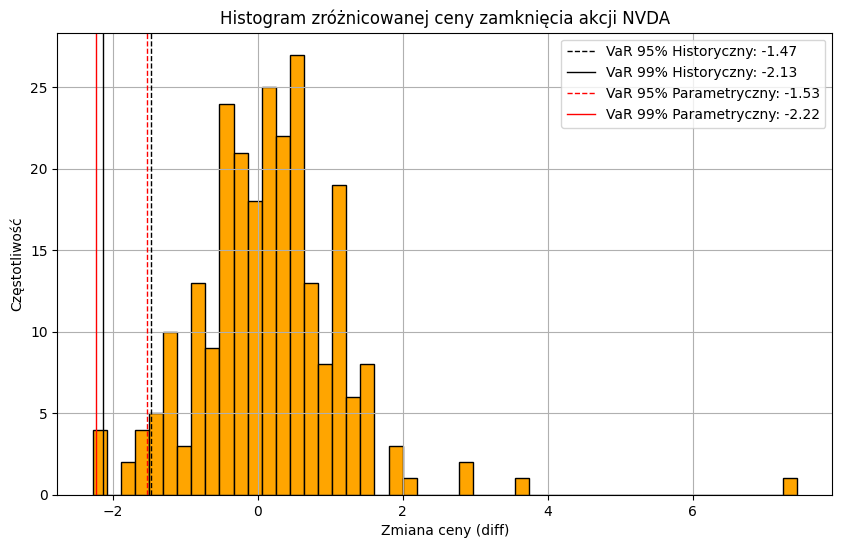

In [31]:
plt.figure(figsize=(10, 6))
data["diff"].hist(bins=50, edgecolor='k', color='orange')
plt.title("Histogram zróżnicowanej ceny zamknięcia akcji NVDA")
plt.xlabel("Zmiana ceny (diff)")
plt.ylabel("Częstotliwość")

# dodanie linii VaR dla podejścia historycznego
plt.axvline(VaR_95_hist, color='black', linestyle='--', linewidth=1, label=f'VaR 95% Historyczny: {VaR_95_hist:.2f}')
plt.axvline(VaR_99_hist, color='black', linestyle='-', linewidth=1, label=f'VaR 99% Historyczny: {VaR_99_hist:.2f}')

# dodanie linii VaR dla podejścia parametrycznego
plt.axvline(VaR_95, color='red', linestyle='--', linewidth=1, label=f'VaR 95% Parametryczny: {VaR_95:.2f}')
plt.axvline(VaR_99, color='red', linestyle='-', linewidth=1, label=f'VaR 99% Parametryczny: {VaR_99:.2f}')

plt.legend()
plt.show()

wnioski...

## Podsumowanie wyników

---

In [ ]:
# Analiza danych – sprawdzenie zakresu i jakości danych (częstotliwość, wartości odstające, rozkład).
# Kalkulacja VaR – przy założeniu normalnego rozkładu (trzeba dopasować mu i sigma) oraz dla rozkładu historycznego z danych.
# Krótkie podsumowanie wyników – word, powerpoint lub dobrze skomentowany i opisany kod programistyczny.

# zysk lub starta

# dane do zyskow i strat, mamy powiedziec co chcemy liczyc, cos tam z var, test na rozklad normalny, komentarzy duzo co widzimy na wykresach